In [2]:
!pip install xgboost
!brew install libomp
!pip install lightgbm
import kagglehub
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
from sklearn.metrics import precision_recall_fscore_support
from sklearn.inspection import permutation_importance
from sklearn.model_selection import train_test_split


# Download dataset
path = kagglehub.dataset_download("uciml/default-of-credit-card-clients-dataset")

==> Auto-updating Homebrew...
Adjust how often this is run with `$HOMEBREW_AUTO_UPDATE_SECS` or disable with
`$HOMEBREW_NO_AUTO_UPDATE=1`. Hide these hints with `$HOMEBREW_NO_ENV_HINTS=1` (see `man brew`).
==> Auto-updated Homebrew!
Updated 2 taps (homebrew/core and homebrew/cask).
==> New Formulae
mq: Jq-like command-line tool for markdown processing
mufetch: Neofetch-style music cli
netshow: Interactive network connection monitor with friendly service names
nkt: TUI for fast and simple interacting with your BibLaTeX database

To reinstall 21.1.7, run:
  brew reinstall libomp


/Users/popthrop/Desktop/DS 340/Final Project/DS340/.venv/lib/python3.13/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
# CSV file in the downloaded directory
for file in os.listdir(path):
    if file.endswith(".csv"):
        csv_file = os.path.join(path, file)
        break

df = pd.read_csv(csv_file)

target_vec = df['default.payment.next.month']
feature_vec = df.drop(['default.payment.next.month','ID'], axis=1)

In [4]:
def evaluate_model(model,x_train,y_train,x_test,y_test):
    model.fit(x_train,y_train)
    y_pred = model.predict(x_test)

    #Evaluations of all models will be based on AUC Score, Precision, Recall, and F score

    precision, recall, fscore, _ = precision_recall_fscore_support(y_test,y_pred)

    print(f'AUC Score: {model.score(x_test,y_test)} \nPrecision: {precision} \nRecall: {recall} \n \
    F Score: {fscore}')

def evaluate_features(model,x_test,y_test,title):
    from sklearn.inspection import permutation_importance

    result = permutation_importance(model, x_test, y_test, n_repeats=15)
    importances = result.importances_mean
    feature_names = feature_vec.columns

    sorted = np.argsort(importances)[::-1] 

    sorted_features = feature_names[sorted]
    sorted_importances = importances[sorted]

    plt.figure(figsize=(10, 6))
    plt.bar(sorted_features, sorted_importances)
    plt.xticks(rotation=90)
    plt.ylabel("Permutation Importance")
    plt.title(title)
    plt.tight_layout()
    plt.show()

In [5]:
x_train, x_test, y_train, y_test = train_test_split(feature_vec, target_vec, train_size=0.8 \
                                                    ,random_state=10)

Baseline Model of Logistic Regression with Cross Validation

AUC Score: 0.7203244550354269 
Precision: [0.87277556 0.37494407] 
Recall: [0.70168695 0.63629461] 
     F Score: [0.77793561 0.47184685]


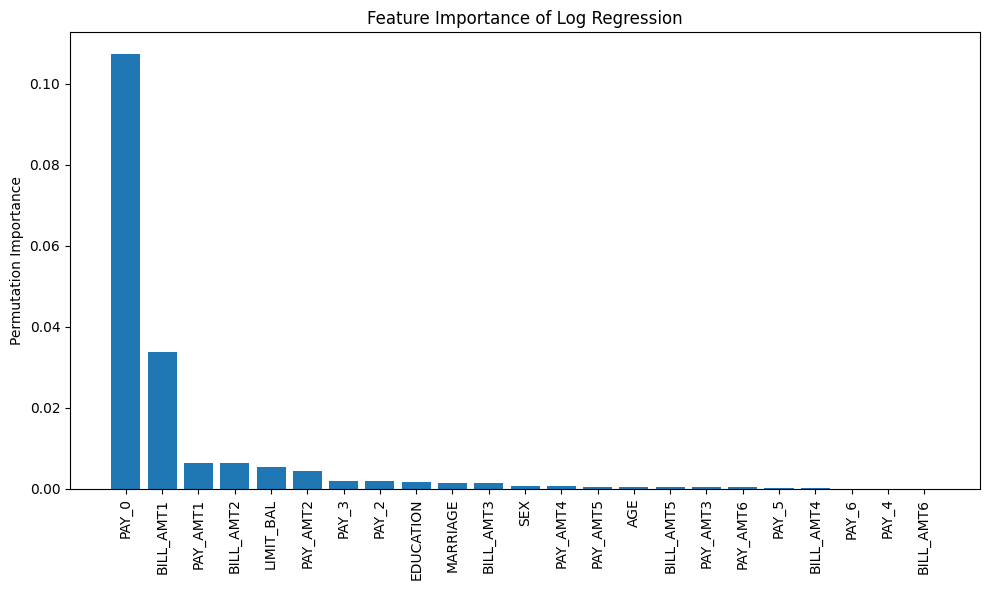

In [7]:
from sklearn.linear_model import LogisticRegressionCV
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

LR_base = Pipeline([
    ('scaler', StandardScaler()),
    ('lr', LogisticRegressionCV(
        cv=5,
        scoring='roc_auc',
        max_iter=5000,
        class_weight='balanced',
        solver="lbfgs",
        n_jobs=-1

    ))
])

title = 'Feature Importance of Log Regression'
evaluate_model(LR_base,x_train,y_train,x_test,y_test)
evaluate_features(LR_base,x_test,y_test,title)

Start to code more advanced ML techniques 

AUC Score: 0.7718876383033608 
Precision: [0.84370836 0.66398929] 
Recall: [0.94640188 0.37661352] 
     F Score: [0.8921095  0.48062016]


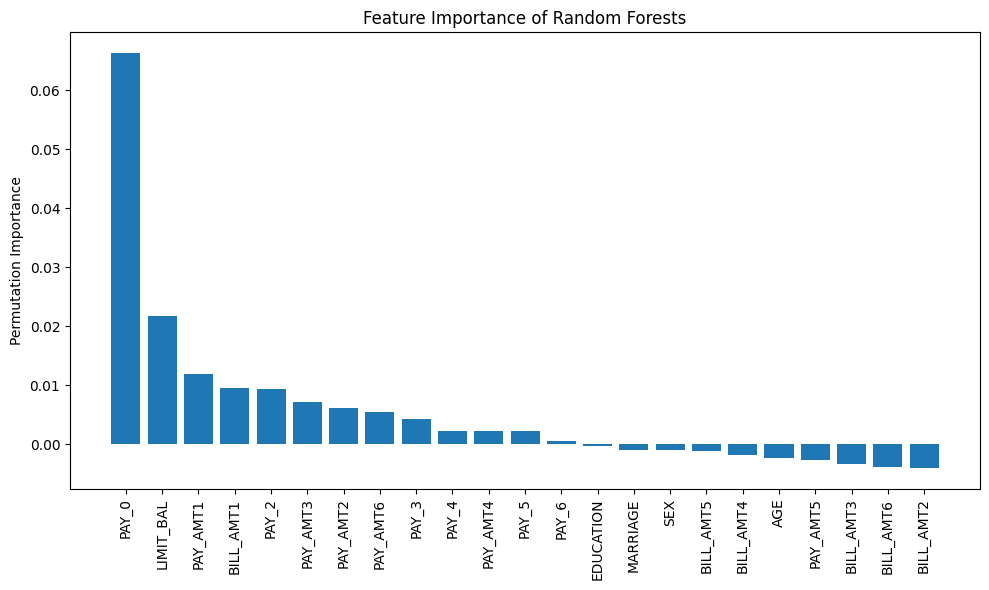

In [8]:
#Random Forests
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV

parameter_grid = {'n_estimators': [10,100,200,500,1000]}

RF = RandomForestClassifier(n_jobs=-1)
RF_gridsearch = GridSearchCV(RF,param_grid=parameter_grid,scoring='roc_auc',cv=5,n_jobs=-1)

title = 'Feature Importance of Random Forests'
evaluate_model(RF_gridsearch,x_train,y_train,x_test,y_test)
evaluate_features(RF_gridsearch,x_test,y_test,title)

AUC Score: 0.7923543225135715 
Precision: [0.84295961 0.69088319] 
Recall: [0.95366218 0.3682612 ] 
     F Score: [0.89490031 0.48043586]


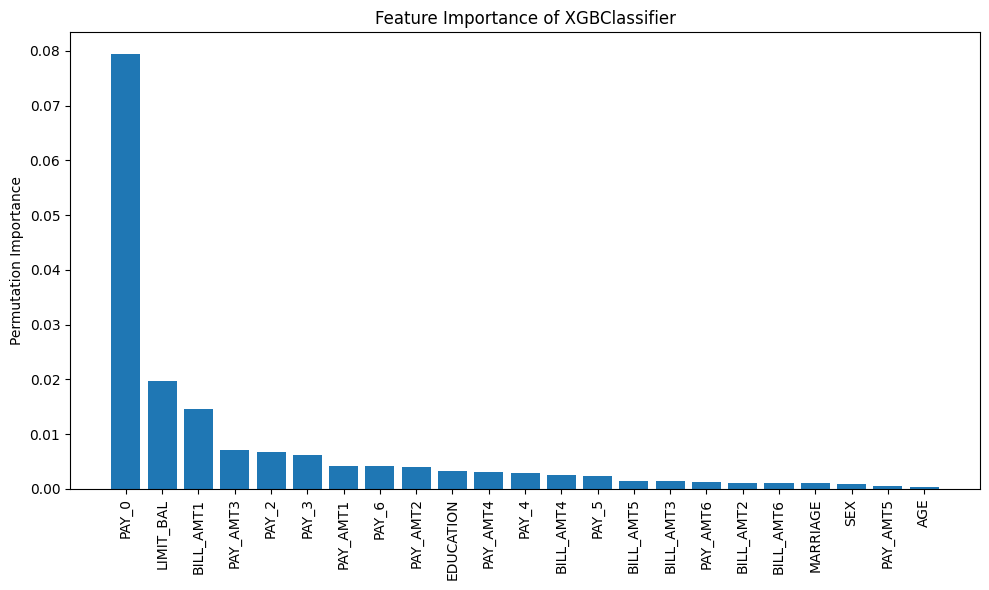

In [9]:
from xgboost import XGBClassifier

parameter_grid = {'n_estimators': [10,100,200,500,1000],'max_depth': [3,4,5,6,7], 'learning_rate': [0.01,0.05,0.1]}
xgb = XGBClassifier(n_jobs=-1)
xgb_gridsearch = GridSearchCV(xgb,param_grid=parameter_grid,scoring='roc_auc',cv=5,n_jobs=-1)

title = 'Feature Importance of XGBClassifier'
evaluate_model(xgb_gridsearch,x_train,y_train,x_test,y_test)
evaluate_features(xgb_gridsearch,x_test,y_test,title)

AUC Score: 0.7912551757102664 
Precision: [0.84357331 0.70172911] 
Recall: [0.95579757 0.3697798 ] 
     F Score: [0.8961858  0.48433615]


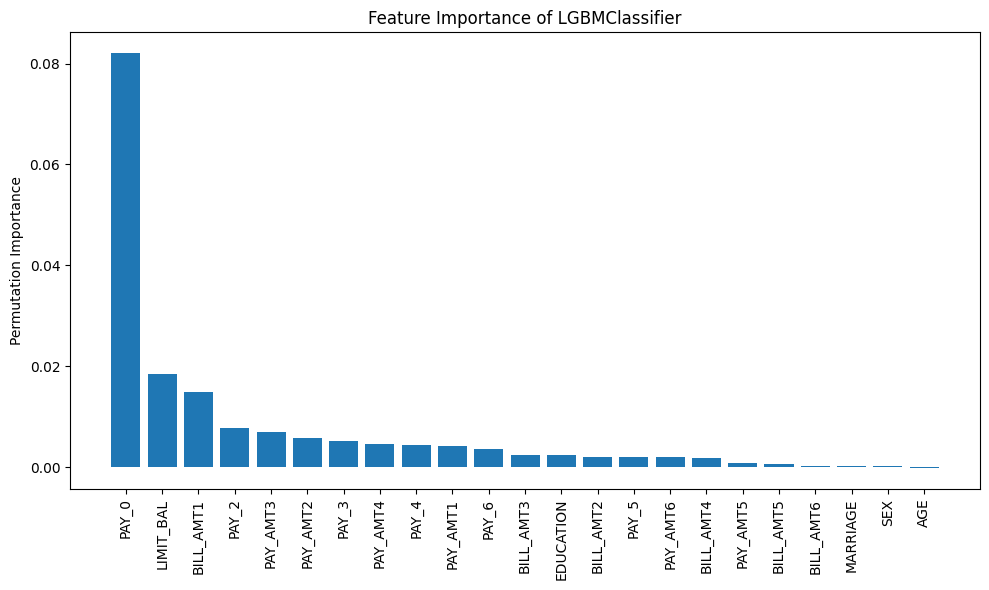

In [10]:
from lightgbm import LGBMClassifier

parameter_grid = {'n_estimators': [100,200,500,1000],'max_depth': [3,5,-1], 'learning_rate': [0.01,0.05,0.1]}
LGBM = LGBMClassifier(verbosity=-1, n_jobs=-1)
LGBM_gridsearch = GridSearchCV(LGBM,param_grid=parameter_grid,scoring='roc_auc',cv=5,n_jobs=-1)

title = 'Feature Importance of LGBMClassifier'
evaluate_model(LGBM_gridsearch,x_train,y_train,x_test,y_test)
evaluate_features(LGBM_gridsearch,x_test,y_test,title)